### Models Experimentation.

**Why use Pycaret?** 

Pros: A Machine-learning pipeline experimentation can be expensive to build, having a broad idea of which methods apply with the help of AutoML can reduce a lot of effort and lead us to make better choices quickly. 

Cons: Pycaret is a heavy-weight library, and having this in production increases the expenses on computational resources. 

**Approach:** Use Pycaret to get insights from modelling and then deploy the bests ones as simple as possible. 

Experiment in three scenarios:

- Almost Raw Data: Only normalize features and track 3 best models.

- SMOTE training: Fix the umbalancing method and track improvements.

- Automated Feature Engineering: Have automated feat eng with 

Things to consider:

1.- The model comparison will sort by F1-Score to avoid recall-prec tradeoff. 

2.- We will exclude SVM and Gradient Boosting Classifier for computational expensiveness.

3.- Top 3 model choices are going to be hand-picked considering F1-score and TT(Sec). The latter considering is a Fraud-credit prediction algorithm and it may be necessary to quick inference. **(Assumption)**

#### Scenario 1: Only Normalization.

Note: Pycaret already use StratifiedKFolds for cross validation.

In [1]:
# LOAD TRAIN
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

#LOAD DATA.
data_path=(
    '../input/',
    )

train = pd.read_csv(data_path[0]+'train.csv')
test = pd.read_csv(data_path[0]+'test.csv')

print('TRAIN SHAPE: {}\nTEST SHAPE:{}'.format(train.shape, test.shape))

#Drop time
train.drop('Time',axis=1, inplace=True)

TRAIN SHAPE: (256326, 33)
TEST SHAPE:(28481, 33)


In [2]:
from pycaret.classification import *

scen_one = setup(train, target='Class', session_id = 1001, normalize=True, 
                 silent = True, experiment_name='scenario 1')

,Description,Value
0,session_id,1001
1,Target,Class
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(256326, 32)"
5,Missing Values,False
6,Numeric Features,31
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [3]:
top3_s1 = compare_models(n_select = 3, sort='F1', exclude=['svm','gbc'])  #Sort by F1 to avoid recall-prec tradeoff view

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9996,0.9483,0.7967,0.9435,0.8629,0.8627,0.8663,14.9930
rf,Random Forest Classifier,0.9996,0.9468,0.7833,0.9481,0.8576,0.8574,0.8615,73.1140
xgboost,Extreme Gradient Boosting,0.9996,0.9766,0.7867,0.9415,0.8564,0.8561,0.8600,65.9640
knn,K Neighbors Classifier,0.9995,0.9216,0.7733,0.9190,0.8389,0.8386,0.8423,189.1450
lda,Linear Discriminant Analysis,0.9994,0.9066,0.7567,0.8889,0.8155,0.8152,0.8189,1.4620
lr,Logistic Regression,0.9993,0.9765,0.6667,0.9084,0.7659,0.7655,0.7763,2.1460
dt,Decision Tree Classifier,0.9991,0.8764,0.7533,0.7454,0.7481,0.7477,0.7483,8.7790
ada,Ada Boost Classifier,0.9992,0.9807,0.6867,0.8212,0.7444,0.7440,0.7487,31.9600
ridge,Ridge Classifier,0.9989,0.0000,0.4333,0.8775,0.5746,0.5741,0.6129,0.3280
lightgbm,Light Gradient Boosting Machine,0.9953,0.7180,0.5333,0.2322,0.3002,0.2985,0.3358,3.0260


We can evaluate our best performing models on the hold-out dataset Pycaret saved for us. We will see the precission-recall curve and the feature selection.

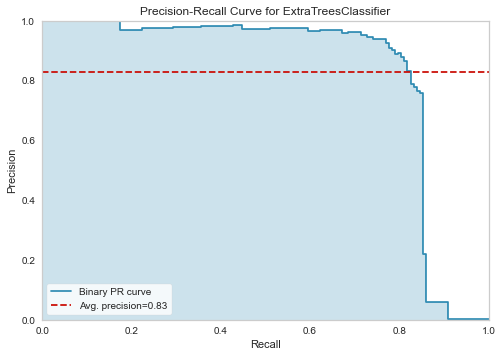

In [16]:
plot_model(top3_s1[0], 'pr')  #ExtraTrees Precision Recall Curve

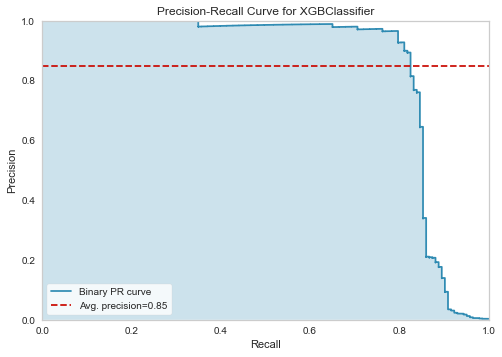

In [26]:
plot_model(top3_s1[2], 'pr') #Xgboost PRC

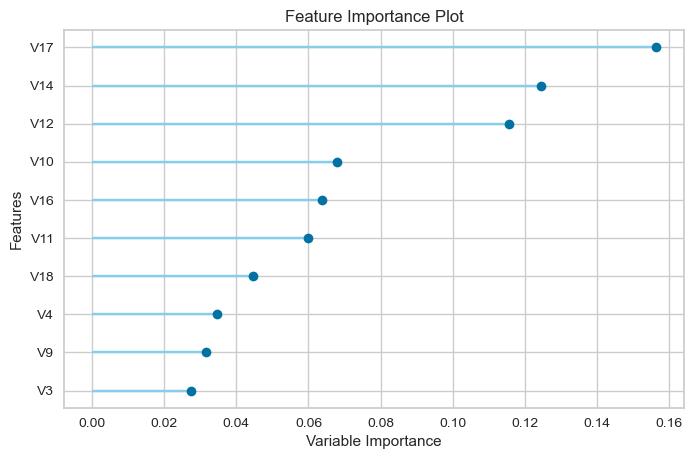

In [17]:
plot_model(top3_s1[0], 'feature')

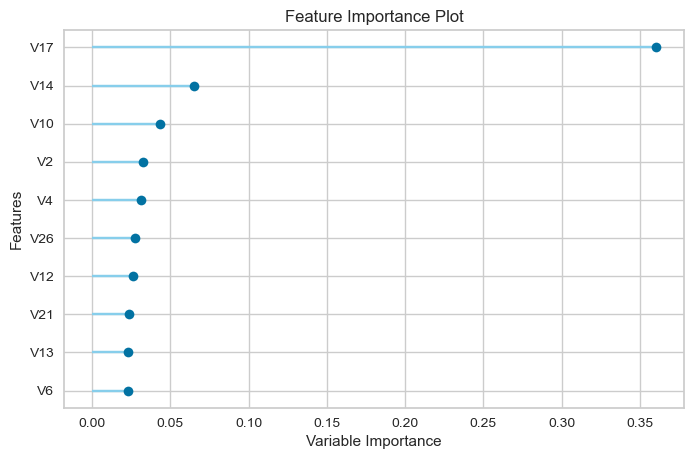

In [27]:
plot_model(top3_s1[2], 'feature') 

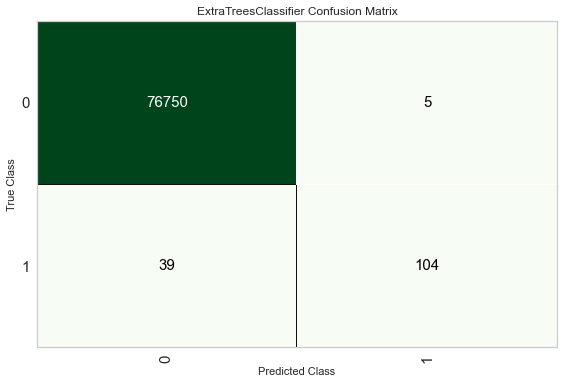

In [28]:
plot_model(top3_s1[0], 'confusion_matrix')

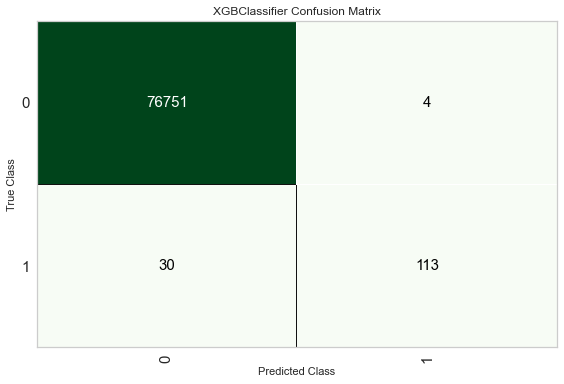

In [29]:
plot_model(top3_s1[2], 'confusion_matrix')

#### Scenario 2: Fix imbalances.

Pycaret uses SMOTE method to fix_imbalance by default.

KNN is droped due to [this](https://www.quora.com/Why-does-knn-get-effected-by-the-class-imbalance) and computation cost.

In [33]:
raw_clf = setup(train, target='Class', session_id = 1002, fix_imbalance=True, normalize=True,
                silent = True, experiment_name='scenario 2')

,Description,Value
0,session_id,1002
1,Target,Class
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(256326, 32)"
5,Missing Values,False
6,Numeric Features,31
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [34]:
top3_s2 = compare_models(n_select = 3, sort='F1', exclude=['svm','gbc','knn'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9996,0.9705,0.8116,0.9296,0.8641,0.8639,0.8671,25.9520
rf,Random Forest Classifier,0.9995,0.9757,0.8019,0.8825,0.8380,0.8377,0.8398,123.1440
xgboost,Extreme Gradient Boosting,0.9993,0.9779,0.8149,0.7967,0.8028,0.8025,0.8040,160.5020
lightgbm,Light Gradient Boosting Machine,0.9989,0.9685,0.8215,0.6512,0.7231,0.7226,0.7292,6.5810
dt,Decision Tree Classifier,0.9976,0.8836,0.7692,0.4001,0.5251,0.5240,0.5530,18.7060
lda,Linear Discriminant Analysis,0.9861,0.9607,0.8019,0.0927,0.1660,0.1634,0.2695,2.3260
ridge,Ridge Classifier,0.9861,0.0000,0.8019,0.0926,0.1659,0.1633,0.2694,0.6940
ada,Ada Boost Classifier,0.9808,0.9720,0.8798,0.0740,0.1365,0.1338,0.2519,57.2410
qda,Quadratic Discriminant Analysis,0.9753,0.9610,0.8670,0.0574,0.1077,0.1048,0.2194,1.4630
nb,Naive Bayes,0.9756,0.9542,0.8508,0.0571,0.1070,0.1041,0.2166,0.8150


In [36]:
top3_s2

[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=1002, verbose=0,
                      warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=-

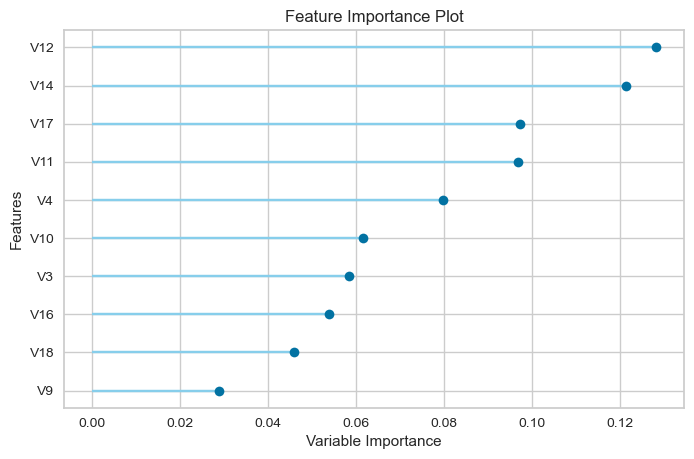

In [37]:
plot_model(top3_s2[0], 'feature') #ExtraTrees

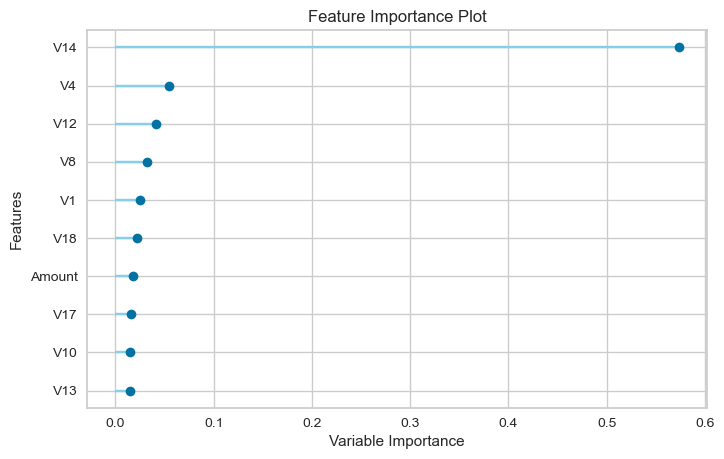

In [38]:
plot_model(top3_s2[2], 'feature') #XGBoost

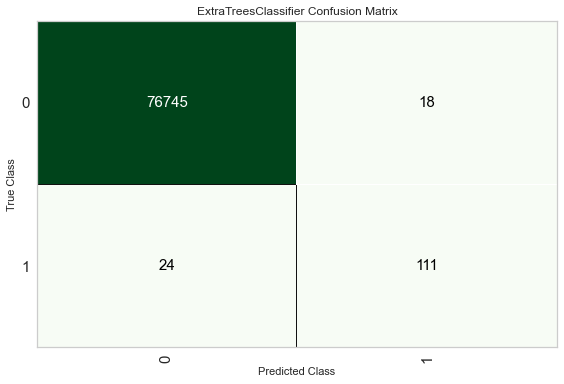

In [40]:
plot_model(top3_s2[0], 'confusion_matrix')

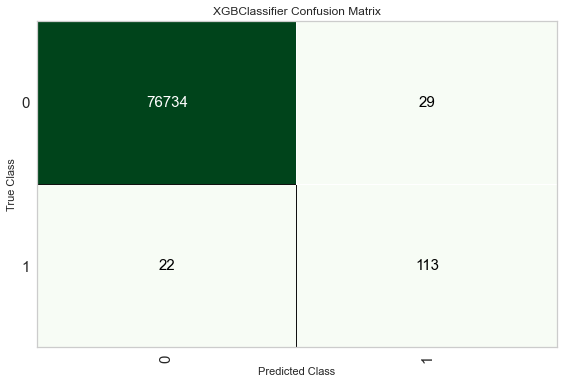

In [41]:
plot_model(top3_s2[2], 'confusion_matrix')

#### Scenario 3: Automated Feature Engineering.

Based on the previous 3 choosen models (and because it's computationally expensive) we will add the automate feat eng feature in pycaret. This involves many interactions between variables, therefore it has to be other filter processes like ``feature_selection`` and ``remove_multicollinearity``. The features the engine will create are: 

- Features combined by arithmetic operations.

- Features ratios of existing features (a/b).

- Categorize 'Amount' feature by 1-D k-means cluster.

All of them will be selected by importance based on Trees models, and the multicollinearity between features will be removed.

*Source: https://pycaret.org/feature-interaction/*

In [105]:
feat_eng = setup(train, target='Class', session_id = 1003, experiment_name='scenario 3', normalize = True,
                 bin_numeric_features = ['Amount'], interaction_threshold = 0.5,
                 remove_multicollinearity=True, multicollinearity_threshold=0.7)

,Description,Value
0,session_id,1003
1,Target,Class
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(256326, 32)"
5,Missing Values,False
6,Numeric Features,31
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [118]:
best_n = compare_models(include=['et','xgboost','lda'], n_select=3, fold=2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9996,0.9797,0.7774,0.9377,0.8499,0.8497,0.8535,27.0450
et,Extra Trees Classifier,0.9995,0.9466,0.7329,0.9468,0.8256,0.8254,0.8325,7.8750
lda,Linear Discriminant Analysis,0.9994,0.8954,0.7534,0.8528,0.7996,0.7993,0.8010,1.9500


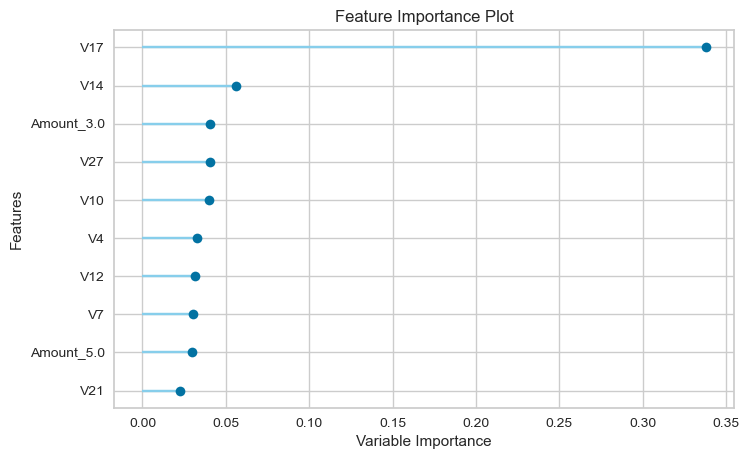

In [119]:
plot_model(best_n[0], 'feature')  #XGBCLassifier

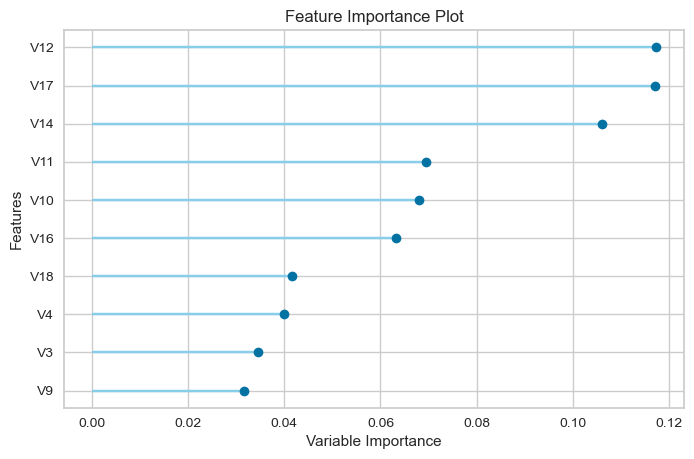

In [120]:
plot_model(best_n[1], 'feature')  #ExtraTreesClassifier

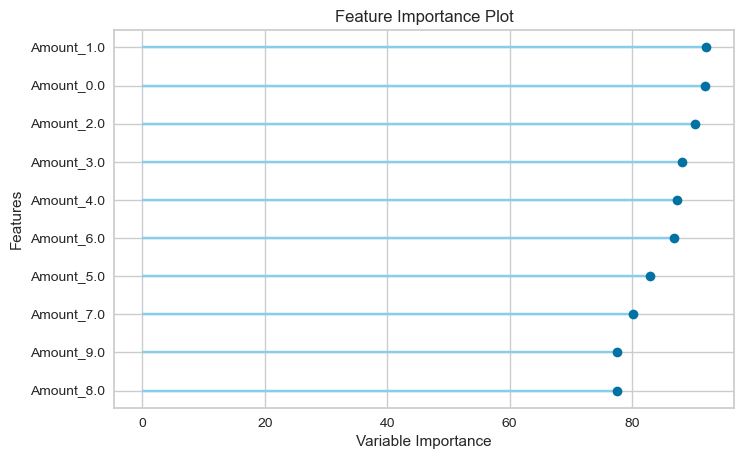

In [122]:
plot_model(best_n[2], 'feature')  #LDA

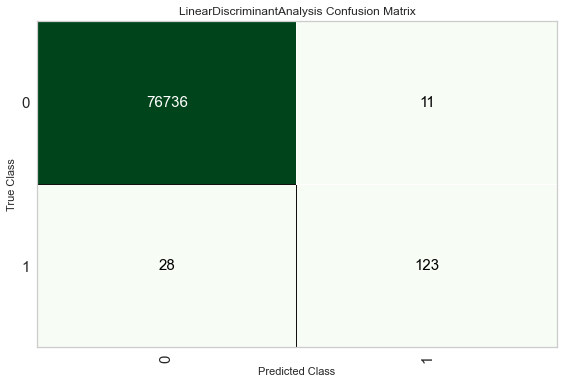

In [128]:
#plot_model(best_n[0],'confusion_matrix')
#plot_model(best_n[1],'confusion_matrix')
plot_model(best_n[2],'confusion_matrix')

### Experimentation Conclusions:

| Method/Model | ExtraTrees | XGBoost | LDA |
| --- | --- | --- | --- |
| Normalize | 86% | 85.64% | 81.55% |
| SMOTE | 86% | 80% | 16% |
| Auto Feat. Eng | 80.5% | 82% | 81% |

<center>Based on F1-Score Metric</center>

**Scenario 1: Raw with Normalization**
- The important features are the anonymized ones (V17, V14, V12,V10) this doesn't allow us to make an intuitive feature engineering.

- The models have high False Negatives Rates, ending with lower recall metric.

**Scenario 2: Fixing Imbalanced data with SMOTE method**

- Using Oversampling methods doesn't have a relevant impact in modelperformance.

- Decreases False Negatives Rates but at the cost of False Positive (FN-FP tradeoff).

- LDA have a drop in performance.

**Scenario 3: Automated Feature Engineering**

- This process have involved many iterations, having not relevant combinations of features and adding a high computational cost and over-dimensionality.

- Even if new features (as Binning Amount) were adding and found relevant, it doesn't make good improvements on the models.


**Decision:**

- Make an ensemble model out of XGBoost, ExtraTrees and LDA. Having these 3 models different theoretical background it can extract better patterns combined.

<h2><center> Choosing Final metrics</center></h2>

A fraud detection algorithm has to consider the costs of making a False Positive and False Negative. In this context, we make an assumption:

**Assumption:** It is more expensive to missclassify a non-Fraud i.e. incurr in False Negative. Because otherwise the costs of False Positive are just involving a second-step classification or a quick call verification.

Nevertheless, we also have to be aware to not increase the False Positives to stubborn the business requirements or the quality of service. 


Metrics to select:

**1.- AUPRC:** Area Under Precision-Recall curve will be the main metric to track performance. 

Complementary metrics.

**2.- F1-Score:** We want to minimize FN but being aware of the precision-recall tradeoff .

**3.- Recall:** Because we want to minimize the False Negatives.

**4.- Precision:** To compare quickly against Recall metric. Due to the precision-recall tradeoff.

Since our dataset is Numeric, without missing values and having many unknown features we could make a quick model to start to iterate over and get better performance. We will start with a XGBoost Classifier since it has good performance over imbalanced classification datasets.

*Sources:*

AUC-PRC: https://sinyi-chou.github.io/python-sklearn-precision-recall/

##### Score functions:

In [18]:
from sklearn.metrics import precision_recall_curve, auc, f1_score, recall_score, precision_score

def auc_precision_recall_curve(y_true, y_preds):
    precision, recall, thresholds = precision_recall_curve(y_true, y_preds)
    #AUC function to calculate AUC of precision recall curve
    auc_precision_recall = auc(recall, precision)
    return auc_precision_recall

def compute_scores(y_true,y_preds):
    """Return a dictionary of results.
    
    It computes 4 metrics for Fraud Detection interests.
    Arguments:
    
    y_true: real labeled data
    y_preds: prediction from the model
    """
    
    scores = {
        'AUC-PRC': auc_precision_recall_curve(y_true, y_preds),
        'F1-score': f1_score(y_true, y_preds),
        'Recall': recall_score(y_true, y_preds),
        'Precision': precision_score(y_true, y_preds)
    }
    
    return scores

def score_report(score_dict, train=False):
    """Printed scores report
    score_dict: dict from compute_scores function output.
    """
    if train:
        print('---'*10)
        print('Train Scores:\n')
        for score_name, score_value in scores.items():
            print(f"{score_name}:  {score_value * 100:.3f%}")
    else:
        print('Test Scores:\n')
        for score_name, score_value in scores.items():
            print(f"{score_name}:  {score_value * 100:.3f%}")

#### EVALUATING MODELS:



In [15]:
def evaluate_model(model, train_data, features, target, kfolds):
    """ Evaluates a model training with Sklearn format
    model: Model Instance.
    train_dataset: pd.DataFrame
    features: List of features to be included.
    target: target name
    kfolds: sklearn object for the cross validation split
    """
    
    importances = {}
    total_results_dict = {}
    num_batch = 0  
    
    for train_index, test_index in kfolds.split(train_data[features], train_data[target]):
        
        x_train, y_train = train_data.loc[train_index, features], train_data.loc[train_index,target]
        x_test, y_test = train_data.loc[test_index, features], train_data.loc[test_index,target]
        
        num_batch += 1
        #TRAIN
        model.fit(np.float32(x_train), np.float32(y_train))
        
        y_test_pred = model.predict(np.float32(x_test))
        
        #RESULTS
        test_results = compute_scores(y_test, y_test_pred)
        total_results_dict['fold_'+str(num_batch)] = test_results
        
        #IMPORTANCES (XGB ONLY)
        if isinstance(model, XGBClassifier):
            importances_dict = get_xgb_imp(model, features)
            importances['fold_'+str(num_batch)] = importances_dict
        
        del x_train, x_test
        gc.collect()
    
    #Total results
    total_results_df = pd.DataFrame(total_results_dict).agg(['mean','std'],axis=1)
    
    #Average importances
    importances = pd.DataFrame(importances).agg('mean',axis=1)  #Out Null Series if is not XGBClassifier
    
    return total_results_df, importances

def get_xgb_imp(xgb_model, features):
    """ Get feature importances 
    xgb_model = Sklearn wrapper of XGBClassifier
    
    Source: https://stackoverflow.com/questions/38212649/feature-importance-with-xgbclassifier
    """
    imp_vals = xgb_model.booster().get_fscore()
    imp_dict = {features[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(features))}
    total = np.array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

def get_errors_index(model,data, y_pred, y_test, error_list=[]):
    """Return the index from the errors
    model: Sklearn type model
    data: dataset pd.DataFrame
    y_pred: array of predictions
    y_true: array of true values
    """
    data['pred'] = y_pred
    data['error'] = np.where(data['pred'] != y_test, 1, 0) #If error: 1 otherwise 0
    
    error_list += x_test[x_test['error']==1].index.values.tolist() #Get error's index
    
    return error_list

#### Voting Classifier: 

We will ensemble the three models previously tested to have a broad picture for each evaluation. Each model has their own False Negative Rate and they are based in three different theoretical approaches: decission trees, gradient boosters and linear discriminant analysis. A Voting Classifier can make a difference in this sense.

*Code Source:* https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/

In [19]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
import gc
SEED = 123

#SELECTED MODELS
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier,VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#SETTINGS BEFORE TEST

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
features = train.drop('Class', axis=1).columns.to_list()
target = 'Class'


# Group of models
estimator = []

estimator.append(('LDA', LinearDiscriminantAnalysis()))

estimator.append(('ET', ExtraTreesClassifier()))

estimator.append(('XGB', XGBClassifier()))

#Voting Classfier

model_voting = VotingClassifier(estimators=estimator, voting='soft')

total_results, importances = evaluate_model(model_voting, train, features, target, skfold)

C:\Users\pablo\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:53:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pablo\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:55:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pablo\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:57:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pablo\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:59:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pablo\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:01:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
total_results

,mean,std
AUC-PRC,0.863460,0.032104
F1-score,0.854309,0.037710
Recall,0.780924,0.061395
Precision,0.945617,0.018518
